# ENEL 645 - Final Project

### Submitted by: Mevin Moncy, Brandon Lac, Mustayeen Abedin, Nur-Alhuda Ali

 	

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install pytorch_fid

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

from pytorch_fid import fid_score

# Config and Seed

In [4]:
# Hyperparameters
config = {
    'seed': 719,
    'batch_size': 1,
    'image_size': (256, 256),
    'normalize': True,
    'augment': False,
    'start_lr': 2e-4,
    'lmbda': 10,
    'idt_coef': 0.5,#7
    'decay_epoch': 0,
    'epochs': 50,
    'in_ch': 3,
    'out_ch': 3
}

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
set_seed(config['seed'])

# Dataset and Dataloader

In [7]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=config['image_size'], normalize=config['normalize'], augment=config['augment']):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        self.augment = augment
        if normalize:
            self.normalize_transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        else:
            self.normalize_transform = None

        if self.augment:
            self.augmentation_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size, pad_if_needed=True),
                transforms.RandomRotation(10)
            ])
        else:
            self.augmentation_transform = None

        self.base_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
        ])

        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        monet_img = Image.open(monet_path)

        if self.augmentation_transform:
            photo_img = self.augmentation_transform(photo_img)
            monet_img = self.augmentation_transform(monet_img)

        photo_img = self.base_transform(photo_img)
        monet_img = self.base_transform(monet_img)

        if self.normalize_transform:
            photo_img = self.normalize_transform(photo_img)
            monet_img = self.normalize_transform(monet_img)

        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))


In [8]:
img_ds = ImageDataset('../input/gan-getting-started/monet_jpg/', '../input/gan-getting-started/photo_jpg/')

In [9]:
img_dl = DataLoader(img_ds, batch_size=config['batch_size'], pin_memory=True)

In [10]:
photo_img, monet_img = next(iter(img_dl))

In [11]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

In [12]:
def show_images(image_loader, num_pairs=2, rows=2, cols=2, save_path='show_images.jpeg'):
    """
    Displays images from the dataset.
    Args:
        image_loader (DataLoader): DataLoader for the images.
        num_pairs (int): Number of image pairs to display.
        rows (int): Number of rows in the display grid.
        cols (int): Number of columns in the display grid.
        title (str): Title for the display.
    """
    if rows * cols < num_pairs * 2:
        raise ValueError("Number of rows and columns is not sufficient to display all image pairs.")
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()
    for i, (photo_img, monet_img) in enumerate(image_loader):
        if i >= num_pairs:
            break
        photo_img = unnorm(photo_img)
        monet_img = unnorm(monet_img)

        # Display photo image
        ax = axes[i * 2]
        ax.imshow(photo_img[0].permute(1, 2, 0))
        ax.set_title('Photo')
        ax.axis('off')

        # Display Monet image
        ax = axes[i * 2 + 1]
        ax.imshow(monet_img[0].permute(1, 2, 0))
        ax.set_title('Monet')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


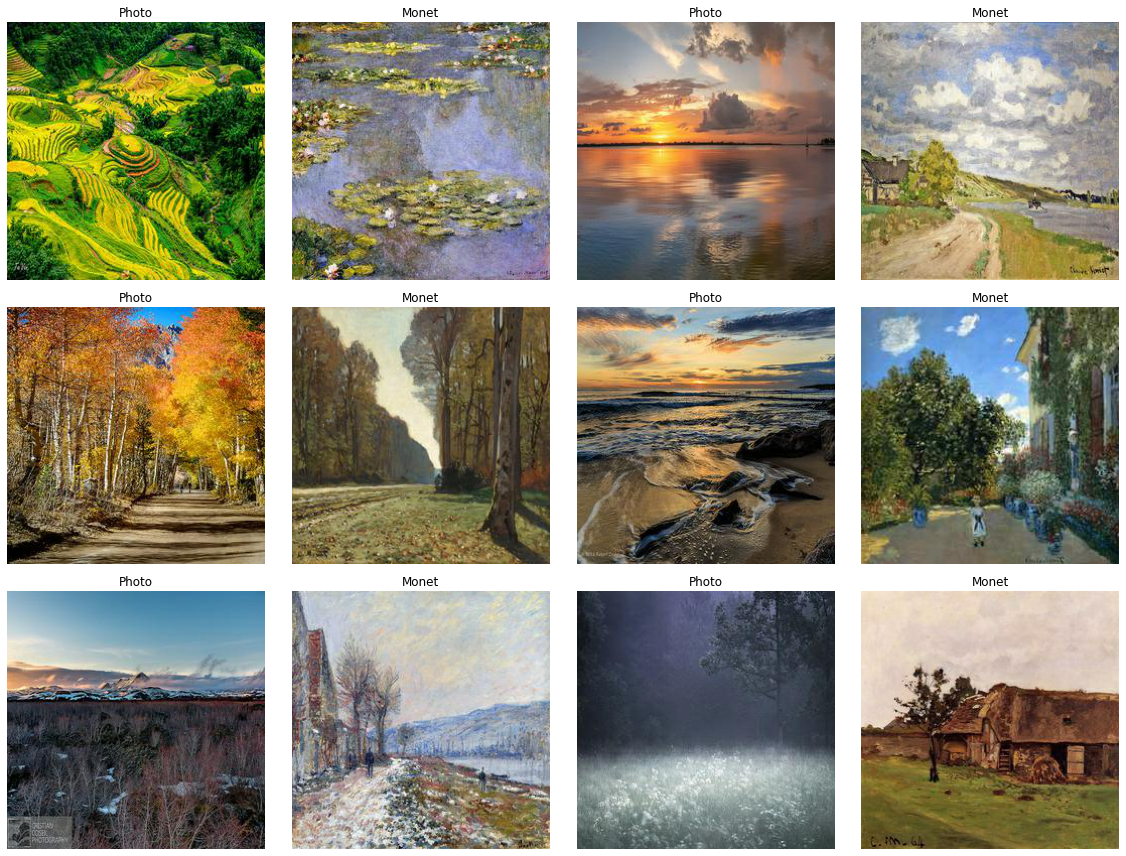

In [13]:
show_images(img_dl, num_pairs=6, rows=3, cols=4)


In [14]:
def dataset_details(image_loader, monet_dir, photo_dir):
    """
    Creates a table listing important details of the dataset.
    Args:
        image_loader (DataLoader): DataLoader for the images.
        monet_dir (str): Directory path for Monet images.
        photo_dir (str): Directory path for photo images.
    Returns:
        pd.DataFrame: DataFrame containing dataset details.
    """
    num_monet_images = len(os.listdir(monet_dir))
    num_photo_images = len(os.listdir(photo_dir))
    num_total_images = num_monet_images + num_photo_images
    batch_size = image_loader.batch_size
    num_batches = len(image_loader)

    data = {
        'Detail': ['Number of Monet images', 'Number of photo images', 'Total number of images', 'Batch size', 'Number of batches'],
        'Value': [num_monet_images, num_photo_images, num_total_images, batch_size, num_batches]
    }

    df = pd.DataFrame(data)
    return df

# Example usage
monet_dir = '../input/gan-getting-started/monet_jpg/'
photo_dir = '../input/gan-getting-started/photo_jpg/'
details_df = dataset_details(img_dl, monet_dir, photo_dir)
print(details_df)

                   Detail  Value
0  Number of Monet images    300
1  Number of photo images   7038
2  Total number of images   7338
3              Batch size      1
4       Number of batches    300


In [15]:
import cv2

def plot_color_distributions(image_loader, num_samples=5):
    """
    Plots the color distributions of a sample of images.
    Args:
        image_loader (DataLoader): DataLoader for the images.
        num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
    for i, (photo_img, monet_img) in enumerate(image_loader):
        if i >= num_samples:
            break
        # Convert images to numpy arrays
        photo_img_np = photo_img[0].permute(1, 2, 0).numpy()
        monet_img_np = monet_img[0].permute(1, 2, 0).numpy()

        # Plot color histograms for photo images
        axes[i, 0].imshow(photo_img_np)
        axes[i, 0].set_title('Photo')

        # Plot color histograms for Monet images
        axes[i, 1].imshow(monet_img_np)
        axes[i, 1].set_title('Monet')
        
    plt.savefig('color_dist.jpeg')
    plt.tight_layout()
    plt.show()


In [16]:
def plot_style_characteristics(image_loader, num_samples=5):
    """
    Plots the style characteristics of a sample of images using edge detection.
    Args:
        image_loader (DataLoader): DataLoader for the images.
        num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 2))
    for i, (photo_img, monet_img) in enumerate(image_loader):
        if i >= num_samples:
            break
        # Convert images to numpy arrays
        photo_img_np = photo_img[0].permute(1, 2, 0).numpy()
        monet_img_np = monet_img[0].permute(1, 2, 0).numpy()

        # Convert to grayscale
        photo_gray = cv2.cvtColor((photo_img_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        monet_gray = cv2.cvtColor((monet_img_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Apply edge detection
        edges_photo = cv2.Canny(photo_gray, 100, 200)
        edges_monet = cv2.Canny(monet_gray, 100, 200)

        # Plot original and edge-detected images
        axes[i, 0].imshow(photo_img_np)
        axes[i, 0].set_title('Photo')

        axes[i, 1].imshow(edges_photo, cmap='gray')
        axes[i, 1].set_title('Photo Edges')

        axes[i, 2].imshow(monet_img_np)
        axes[i, 2].set_title('Monet')

        axes[i, 3].imshow(edges_monet, cmap='gray')
        axes[i, 3].set_title('Monet Edges')
        
    plt.savefig('style_dist.jpeg')
    plt.tight_layout()
    plt.show()


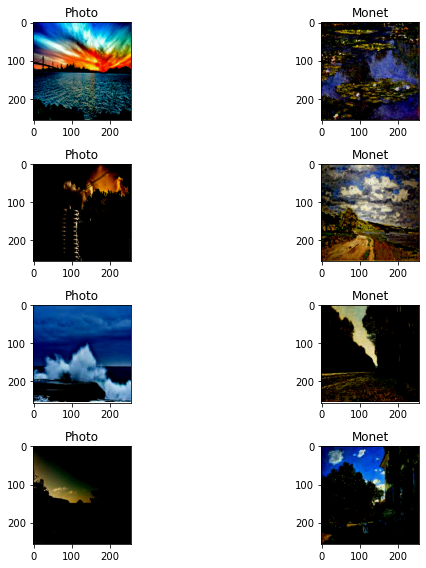

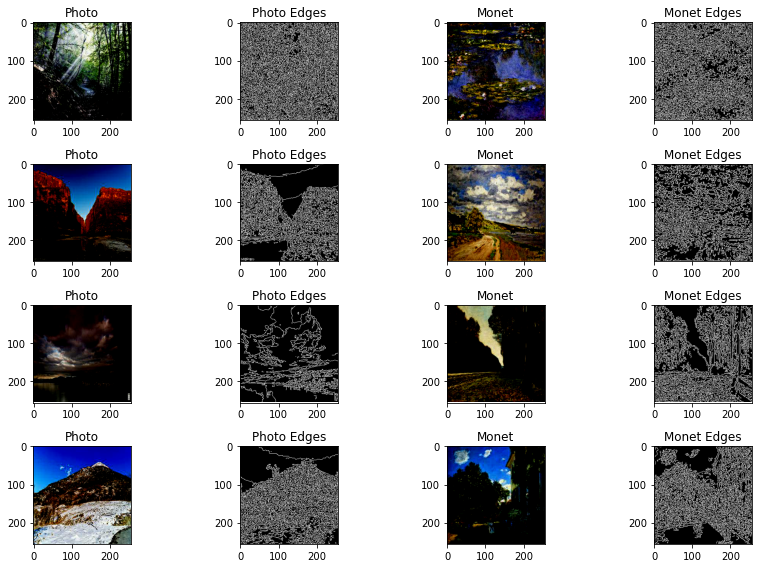

In [17]:
plot_color_distributions(img_dl, num_samples=4)
plot_style_characteristics(img_dl, num_samples=4)


# Save and Load

In [18]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [19]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

# Model

In [20]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )

In [21]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

In [22]:
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

In [23]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [24]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [25]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

# Some additional classes and functions

In [26]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [27]:
# https://arxiv.org/pdf/1612.07828.pdf
# Save 50 generated fake imgs and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [28]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [29]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

# GAN Class

In [30]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = torch.nn.DataParallel(Generator(in_ch, out_ch)).to(self.device)
        self.gen_ptm = torch.nn.DataParallel(Generator(in_ch, out_ch)).to(self.device)
        self.desc_m = torch.nn.DataParallel(Discriminator(in_ch)).to(self.device)
        self.desc_p = torch.nn.DataParallel(Discriminator(in_ch)).to(self.device)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        self.total_training_time = 0  # Add this line to store total training time
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl, start_epoch=0):
        training_start_time = time.time()  # Start timing the entire training process
        for epoch in range(start_epoch, self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(self.device), monet_real.to(self.device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': gan.gen_mtp.state_dict(),
                'gen_ptm': gan.gen_ptm.state_dict(),
                'desc_m': gan.desc_m.state_dict(),
                'desc_p': gan.desc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()
            
        # After training, calculate the total training time
        training_end_time = time.time()
        self.total_training_time = training_end_time - training_start_time
        print(f'Total training time: {self.total_training_time:.2f} seconds')

In [31]:
gan = CycleGAN(config['in_ch'], config['out_ch'], config['epochs'], device, start_lr=config['start_lr'], lmbda=config['lmbda'], idt_coef=config['idt_coef'], decay_epoch=config['decay_epoch'])

In [32]:
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [33]:
save_checkpoint(save_dict, 'init.ckpt')

In [34]:
# Path to the checkpoint file
checkpoint_path = 'current.ckpt'

# Check if the checkpoint exists
if os.path.exists(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    gan.gen_mtp.load_state_dict(checkpoint['gen_mtp'])
    gan.gen_ptm.load_state_dict(checkpoint['gen_ptm'])
    gan.desc_m.load_state_dict(checkpoint['desc_m'])
    gan.desc_p.load_state_dict(checkpoint['desc_p'])
    gan.adam_gen.load_state_dict(checkpoint['optimizer_gen'])
    gan.adam_desc.load_state_dict(checkpoint['optimizer_desc'])
    start_epoch = checkpoint['epoch']
    print(f'Resuming training from epoch {start_epoch}')
else:
    # Start from scratch
    start_epoch = 0
    print('Starting training from scratch')

# Train the model
gan.train(img_dl, start_epoch=start_epoch)

Starting training from scratch


Epoch: (1) | Generator Loss:11.101864 | Discriminator Loss:0.831336


Epoch: (2) | Generator Loss:9.746729 | Discriminator Loss:0.463961


Epoch: (3) | Generator Loss:9.015580 | Discriminator Loss:0.449998


Epoch: (4) | Generator Loss:8.821950 | Discriminator Loss:0.412404


Epoch: (5) | Generator Loss:8.473732 | Discriminator Loss:0.397147


Epoch: (6) | Generator Loss:8.308981 | Discriminator Loss:0.381497


Epoch: (7) | Generator Loss:8.192429 | Discriminator Loss:0.379554


Epoch: (8) | Generator Loss:8.149328 | Discriminator Loss:0.353050


Epoch: (9) | Generator Loss:8.055731 | Discriminator Loss:0.341982


Epoch: (10) | Generator Loss:7.867934 | Discriminator Loss:0.369409


Epoch: (11) | Generator Loss:8.020972 | Discriminator Loss:0.356024


Epoch: (12) | Generator Loss:7.794910 | Discriminator Loss:0.412800


Epoch: (13) | Generator Loss:7.425079 | Discriminator Loss:0.397226


Epoch: (14) | Generator Loss:7.347157 | Discriminator Loss:0.399995


Epoch: (15) | Generator Loss:7.225681 | Discriminator Loss:0.408371


Epoch: (16) | Generator Loss:7.086453 | Discriminator Loss:0.414945


Epoch: (17) | Generator Loss:7.184874 | Discriminator Loss:0.392095


Epoch: (18) | Generator Loss:7.092213 | Discriminator Loss:0.389417


Epoch: (19) | Generator Loss:7.123975 | Discriminator Loss:0.381469


Epoch: (20) | Generator Loss:6.877033 | Discriminator Loss:0.381727


Epoch: (21) | Generator Loss:7.004031 | Discriminator Loss:0.378734


Epoch: (22) | Generator Loss:6.893516 | Discriminator Loss:0.376546


Epoch: (23) | Generator Loss:6.955435 | Discriminator Loss:0.364924


Epoch: (24) | Generator Loss:7.137001 | Discriminator Loss:0.360564


Epoch: (25) | Generator Loss:6.843306 | Discriminator Loss:0.352482


Epoch: (26) | Generator Loss:6.716518 | Discriminator Loss:0.362428


Epoch: (27) | Generator Loss:6.789393 | Discriminator Loss:0.342405


Epoch: (28) | Generator Loss:6.784496 | Discriminator Loss:0.330065


Epoch: (29) | Generator Loss:6.833678 | Discriminator Loss:0.316202


Epoch: (30) | Generator Loss:6.497877 | Discriminator Loss:0.319779


Epoch: (31) | Generator Loss:6.447443 | Discriminator Loss:0.316690


Epoch: (32) | Generator Loss:6.569163 | Discriminator Loss:0.300142


Epoch: (33) | Generator Loss:6.480749 | Discriminator Loss:0.298328


Epoch: (34) | Generator Loss:6.332076 | Discriminator Loss:0.278453


Epoch: (35) | Generator Loss:6.393525 | Discriminator Loss:0.276936


Epoch: (36) | Generator Loss:6.348168 | Discriminator Loss:0.277135


Epoch: (37) | Generator Loss:6.143854 | Discriminator Loss:0.260371


Epoch: (38) | Generator Loss:6.265992 | Discriminator Loss:0.258218


Epoch: (39) | Generator Loss:6.231885 | Discriminator Loss:0.255697


Epoch: (40) | Generator Loss:6.160479 | Discriminator Loss:0.242286


Epoch: (41) | Generator Loss:6.154096 | Discriminator Loss:0.240031


Epoch: (42) | Generator Loss:6.085150 | Discriminator Loss:0.228094


Epoch: (43) | Generator Loss:5.947683 | Discriminator Loss:0.216878


Epoch: (44) | Generator Loss:5.978060 | Discriminator Loss:0.203377


Epoch: (45) | Generator Loss:5.968636 | Discriminator Loss:0.175548


Epoch: (46) | Generator Loss:5.946428 | Discriminator Loss:0.169964


Epoch: (47) | Generator Loss:5.980109 | Discriminator Loss:0.169876


Epoch: (48) | Generator Loss:5.909362 | Discriminator Loss:0.162087


Epoch: (49) | Generator Loss:5.917792 | Discriminator Loss:0.160724


Epoch: (50) | Generator Loss:5.919307 | Discriminator Loss:0.147178
Total training time: 8224.38 seconds


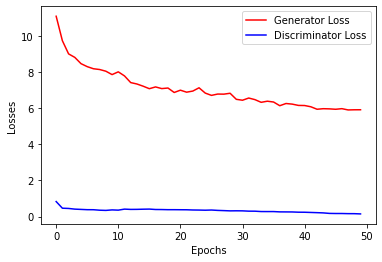

<Figure size 432x288 with 0 Axes>

In [35]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Discriminator Loss')
plt.legend()
plt.show()
plt.savefig('Loss_compared_.jpeg')

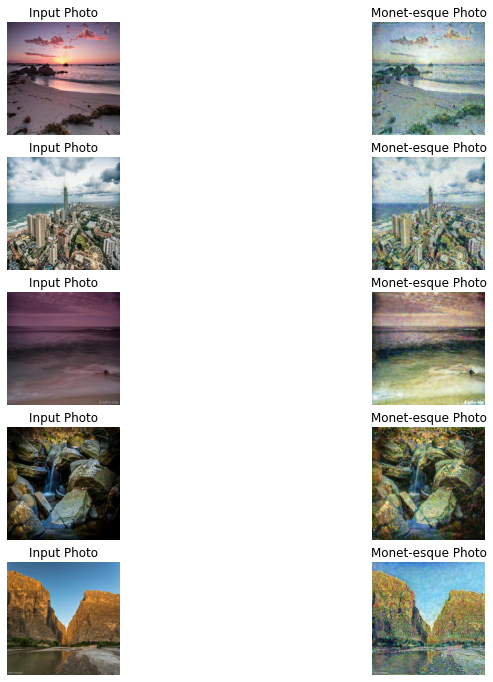

In [36]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Run Generator over all images

In [37]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

In [38]:
ph_ds = PhotoDataset('../input/gan-getting-started/photo_jpg/')

In [39]:
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

In [40]:
!mkdir ../images

In [41]:
trans = transforms.ToPILImage()

In [42]:
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save("../images/" + str(i+1) + ".jpg")

In [43]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [44]:
# Directory paths
real_images_dir = '../input/gan-getting-started/monet_jpg/'
generated_images_dir = '../images/'

# Calculate FID score
fid = fid_score.calculate_fid_given_paths([real_images_dir, generated_images_dir], batch_size=50, device=device, dims=2048)

# Print the FID score
print(f'FID Score: {fid}')


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 141/141 [00:20<00:00,  6.85it/s]


FID Score: 101.4738312153741
